# Part-2 : Correlation, VIF and Dimensionality Reduction using PCA

## Initial Setup

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from datetime import datetime

## Load Data

We will load the `curse-of-dimensionality.xlsx` file. Since there are multiple sheets, we will start by analyzing the first sheet. The same analysis can be repeated for other sheets.

## Sheet 1 only has two columns and 10 data, which is not worth reducing the samples and doing any of the calculations. It does not need to be treated for curse-of-dimentionality processing. The data can be used with linear regression and predictions for x(independent) vs Y (dependant) will be fair.

## Processing Sheet 2 and Sheet 3 here.

In [89]:
try:
    xls = pd.ExcelFile('curse-of-dimensionality.xlsx')
    sheet_names = xls.sheet_names
    del sheet_names[0]
    print(f"Available sheets: {sheet_names}")
    # For this exercise, we will use the second and third sheets.
    df = []
    df.append(pd.read_excel(xls, sheet_name=sheet_names[0]))
    df.append(pd.read_excel(xls, sheet_name=sheet_names[1]))
    print(f"\nData from sheet: '{sheet_names[0]}'")
    df[0].head()
    print(f"\nData from sheet: '{sheet_names[1]}'")
    df[1].head()

except FileNotFoundError:
    print("Error: 'curse-of-dimensionality.xlsx' not found. Please make sure the file is in the correct directory.")

Available sheets: ['Sheet2', 'Sheet3']

Data from sheet: 'Sheet2'

Data from sheet: 'Sheet3'


### Data Exploration
Let's explore the data to understand its structure.

In [90]:
for i in range(len(df)):
    print(sheet_names[i], "\n", "=" * 40)
    print(df[i].info(),
    df[i].describe().to_string())

Sheet2 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       10 non-null     float64
 1   x1      10 non-null     float64
 2   x2      10 non-null     float64
 3   x3      10 non-null     float64
 4   x4      10 non-null     float64
 5   x5      10 non-null     float64
 6   x6      10 non-null     float64
 7   x7      10 non-null     float64
 8   x8      10 non-null     float64
dtypes: float64(9)
memory usage: 852.0 bytes
None                y         x1         x2         x3         x4         x5         x6         x7         x8
count  10.000000  10.000000  10.000000  10.000000  10.000000  10.000000  10.000000  10.000000  10.000000
mean    0.720603   0.141026   0.025312   0.005100   0.140178   0.139358  -0.935088   0.359780   0.500238
std     0.270297   0.077632   0.022468   0.005795   0.076739   0.075882   0.318348   0.113450   0.110456
min     0.2470

### 1. Decrease the number of observations

We will decrease the number of observations and see how it impacts the model's performance. We will assume the last column is the target variable.

 Data from Sheet2 
  40% observations (4): R2=nan, MAE=0.0319,RMSE=0.0319
  52% observations (5): R2=nan, MAE=2.8096,RMSE=2.8096
  65% observations (6): R2=-5.0691, MAE=0.4288,RMSE=0.5138
  78% observations (7): R2=-1.2983, MAE=0.2936,RMSE=0.3162
  90% observations (9): R2=-300.0604, MAE=1.8453,RMSE=2.0515


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


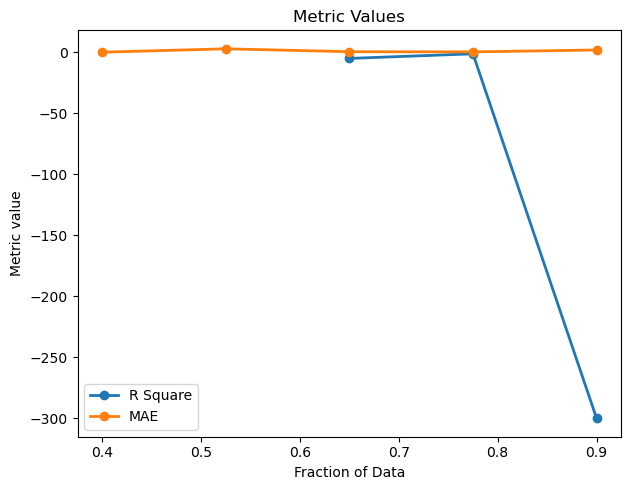

 Data from Sheet3 
  40% observations (39): R2=0.9068, MAE=0.2577,RMSE=0.3256
  52% observations (51): R2=0.8803, MAE=0.2276,RMSE=0.2754
  65% observations (64): R2=-137.5598, MAE=2.5585,RMSE=8.0841
  78% observations (76): R2=0.8281, MAE=0.2975,RMSE=0.3907
  90% observations (89): R2=0.8656, MAE=0.2732,RMSE=0.3061


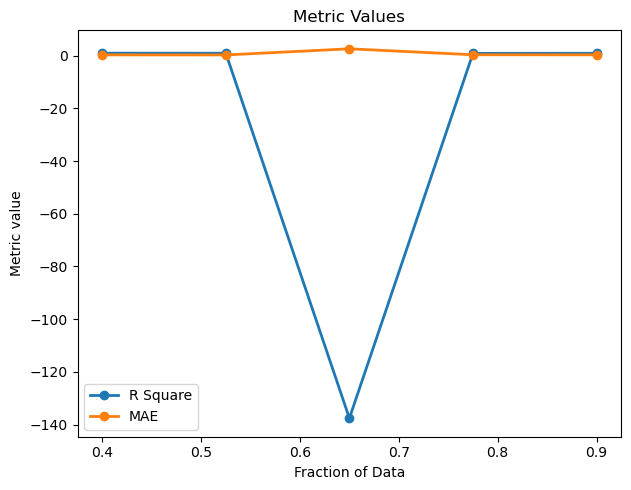

In [91]:
def calculate_metrics_and_plot(df, fractions):
    r2_scores_fun = []
    mae_scores_fun = []
    rmse_scores_fun = []

    for frac in fractions:
        sample_size = int(frac * len(df))
        if sample_size < 3:  # Need minimum 3 samples for train/test split
            r2_scores_fun.append(np.nan)
            mae_scores_fun.append(np.nan)
            rmse_scores_fun.append(np.nan)
            continue

        df_sample = df.sample(n=sample_size, random_state=42)
        
        X_sample = df_sample.iloc[:, 1:]
        y_sample = df_sample.iloc[:, 0]
        
        X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)
        
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        r2_scores_fun.append(r2_score(y_test, y_pred))
        mae_scores_fun.append(mean_absolute_error(y_test, y_pred))
        rmse_scores_fun.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        print(f"  {frac*100:.0f}% observations ({sample_size}): R2={r2_scores_fun[-1]:.4f}, MAE={mae_scores_fun[-1]:.4f},"+
               f"RMSE={rmse_scores_fun[-1]:.4f}")

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(fractions, r2_scores_fun, marker='o', label='R Square', linewidth = 2)
    plt.plot(fractions, mae_scores_fun, marker='o', label='MAE', linewidth=2)
    plt.title('Metric Values')
    plt.xlabel('Fraction of Data')
    plt.ylabel('Metric value')

    plt.tight_layout()
    plt.legend()
    plt.show()
    return r2_scores_fun, mae_scores_fun, rmse_scores_fun

r2_scores = []
mae_scores = []
rmse_scores = []

fractions = np.linspace(0.4, 0.9, 5)

for i in range(len(df)):
    print(" Data from " + sheet_names[i], "\n", "=" * 40)
    r2, mae, rmse = calculate_metrics_and_plot(df[i], fractions)
    r2_scores.append(r2)
    mae_scores.append(mae)
    rmse_scores.append(rmse)


In [92]:
for i in range(len(r2_scores)):
    print(" Data from " + sheet_names[i], "\n", "=" * 40)
    # print(fractions)
    # print(r2_scores[i])
    # print(mae_scores[i])
    table1 = pd.DataFrame(zip(fractions, r2_scores[i], mae_scores[i]), columns=["fractions", "r2 score", "mae score"])
    print(table1)
    print( "=" * 80)


 Data from Sheet2 
   fractions    r2 score  mae score
0      0.400         NaN   0.031938
1      0.525         NaN   2.809621
2      0.650   -5.069112   0.428843
3      0.775   -1.298278   0.293579
4      0.900 -300.060434   1.845331
 Data from Sheet3 
   fractions    r2 score  mae score
0      0.400    0.906842   0.257710
1      0.525    0.880273   0.227636
2      0.650 -137.559787   2.558536
3      0.775    0.828139   0.297467
4      0.900    0.865604   0.273242


#### Take Aways
##### Sheet 2 only has 10 data, the number itself is too small to train and test a model. So metrics values are randomly changing with different sample sizes. Advisable not to use so less row data.

##### Sheet 3 has an unexplained negative spike for 65 observations in R square value. It is worst then predicting the mean of data. For rest of the observations have good score for the given dataset.

### 2. Pair-wise Correlation Analysis

 Data from Sheet2 


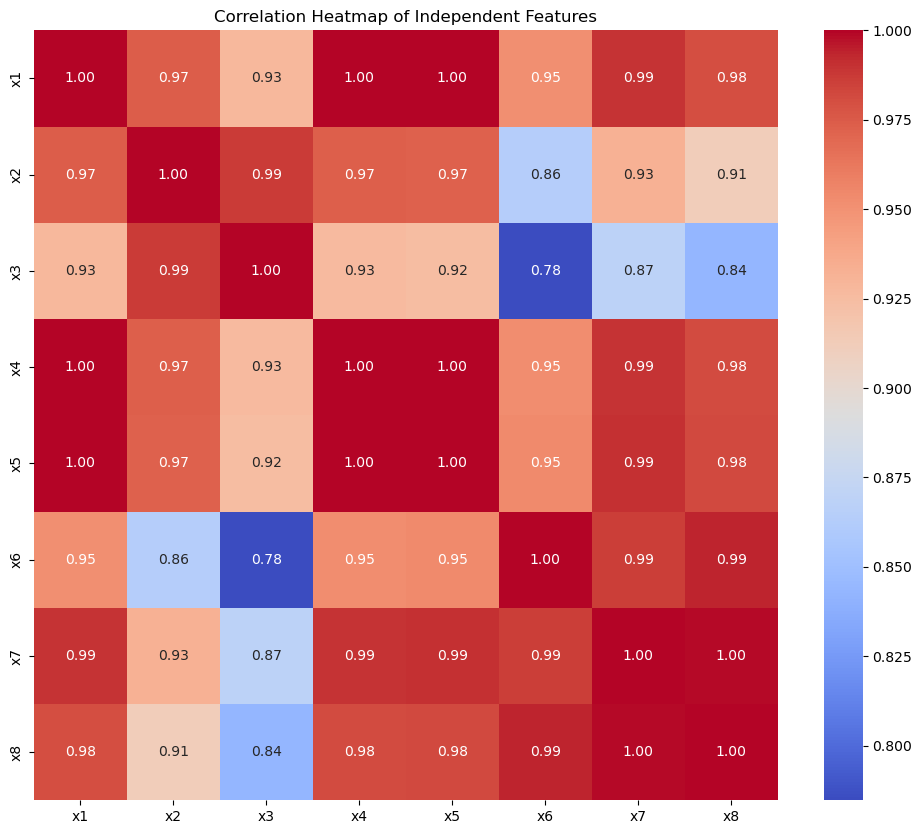

 Data from Sheet3 


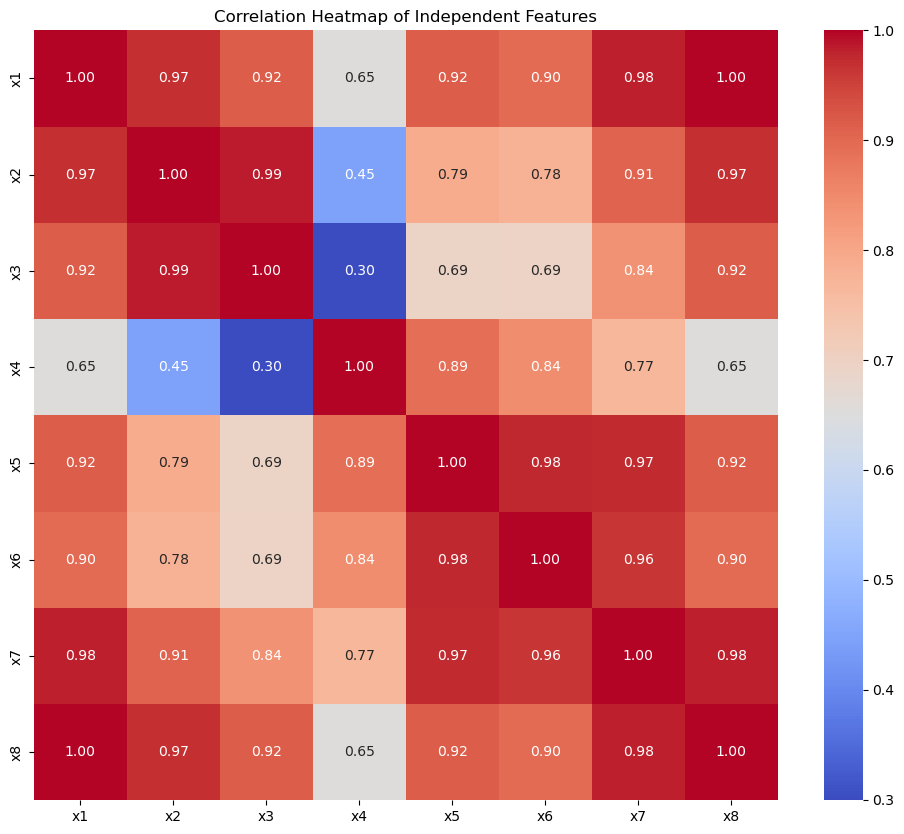

In [93]:
def pair_wise_correlation(X):
    plt.figure(figsize=(12, 10))
    sns.heatmap(X.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap of Independent Features')
    plt.show()

for i in range(len(df)):
    print(" Data from " + sheet_names[i], "\n", "=" * 40)
    pair_wise_correlation( df[i].iloc[:, 1:])
    print( "=" * 80)


**Observations:**

- Based on the above heat map, for *Sheet 2* , all columns are highly correlated, probably due to the less number of observations and less variety of data.
- For *Sheet 3* , X1 and X8 columns are highly correlated, with correlation factor of 1, it can be easily be replaced by single column representing them both.
- Same way, X2 and X3 are next best correlated with 0.99 correlation factor.
- Since X7 is also highly correlated with x1 and x8, correlation factor 0.98, this can be next logical feature elementation.
- Next best is X5 and X6 with correlation factor of 0.97

**Interpretation from Pairwise Heatmap analysis**

Heatmaps for Sheet 2 & 3 display most pairs are extremely collinear, meaning they carry overlapping information.

We might consider:
- Dropping one feature from each pair
- Applying PCA or VIF-based pruning

### 3. VIF Analysis

In [94]:
for i in range(len(df)):
    vif_data = pd.DataFrame()
    X = df[i].iloc[:,1:]
    vif_data['feature'] = df[i].iloc[:, 1:].columns.to_list()
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

    print(" Data from " + sheet_names[i], "\n", "=" * 40)
    print(vif_data)

 Data from Sheet2 
  feature           VIF
0      x1           inf
1      x2  8.704497e+08
2      x3  8.263486e+13
3      x4           inf
4      x5  9.007199e+15
5      x6  1.887775e+07
6      x7  2.029083e+10
7      x8  1.012388e+10
 Data from Sheet3 
  feature           VIF
0      x1           inf
1      x2  1.724240e+06
2      x3  1.307116e+05
3      x4  3.311275e+04
4      x5  2.910978e+05
5      x6  3.167700e+01
6      x7  2.931656e+04
7      x8           inf


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


**Observations:**

- both sheets 2 and 3 have Perfect Multicollinearity.
The features are mathemitcally identical to each other and model can't tell x1 apart from rest of features.

- Duplicate Columns: $x_1$ is an exact copy of $x_4$.

**Why did it change between Sheet2 and Sheet3?
- Sheet2 (fewer observations) has higher numbers ($10^{15}$) than Sheet3 ($10^6$). 
- Sheet2 (High Multicollinearity): With fewer data points, it is easier for variables to look "accidentally" perfect.
- Sheet3: With more data, the "perfect" relationship breaks slightly (noise is introduced), so inf might drop to a "massive number" (like $1.7e+06$), but the structural problem remains.


### 4. Progressive VIF Analysis


Progressive VIF-BASED feature Elimination for each sheet
 Data from Sheet2 


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


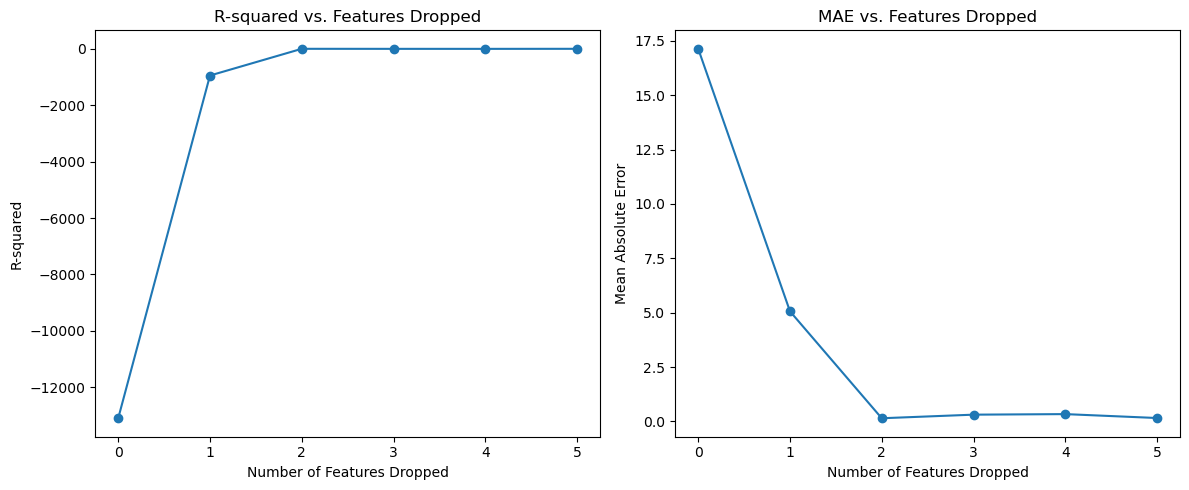

Dropped features: ['x1', 'x4', 'x7', 'x5', 'x2', 'x8']
dropped feature      R-Square       MAE
             x1 -13097.161510 17.133580
             x4   -946.532591  5.063305
             x7      0.354219  0.147443
             x5     -1.244082  0.312414
             x2     -1.693956  0.337825
             x8      0.319276  0.158091
 Data from Sheet3 


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


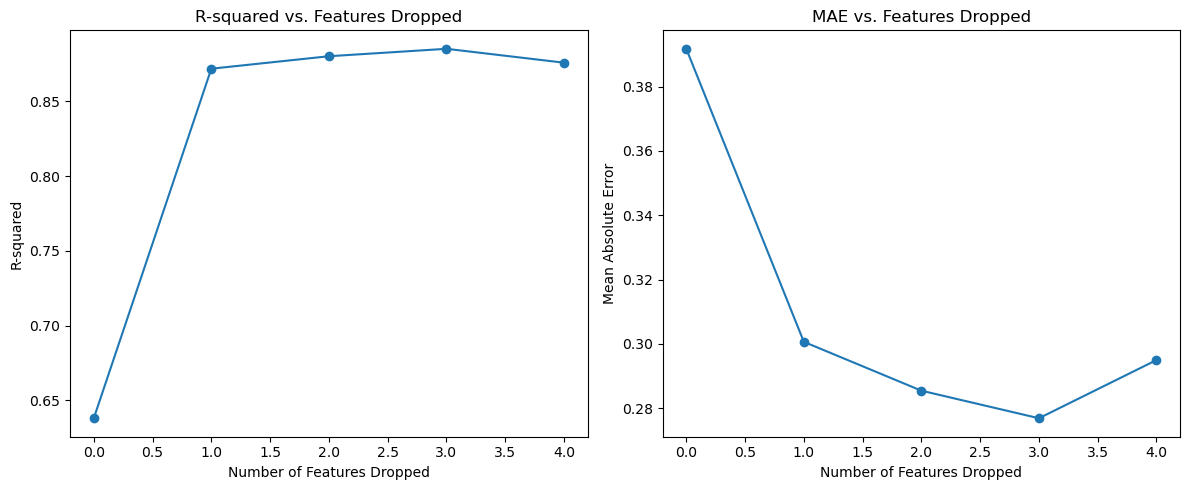

Dropped features: ['x1', 'x8', 'x5', 'x3', 'x7']
dropped feature  R-Square      MAE
             x1  0.637927 0.391760
             x8  0.871862 0.300672
             x5  0.880206 0.285486
             x3  0.885177 0.276917
             x7  0.875887 0.295009


In [95]:
print("\n" + "=" * 60)
print("Progressive VIF-BASED feature Elimination for each sheet")
print("=" * 60)

for i in range(len(df)):
    X_vif = df[i].iloc[:,1:].copy()
    y = df[i].iloc[:,:1].copy()
    r2_vif = []
    mae_vif = []
    dropped_features = []

    print(" Data from " + sheet_names[i], "\n", "=" * 40)

    for _ in range(len(X.columns) -1):
        vif = pd.DataFrame()
        vif['feature'] = X_vif.columns
        vif['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]
        
        max_vif = vif['VIF'].max()
        if max_vif > 5:
            drop_feature = vif.sort_values('VIF', ascending=False)['feature'].iloc[0]
            X_vif = X_vif.drop(columns=[drop_feature])
            dropped_features.append(drop_feature)
            
            X_train, X_test, y_train, y_test = train_test_split(X_vif, y, test_size=0.2, random_state=42)
            model = LinearRegression()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            r2_vif.append(r2_score(y_test, y_pred))
            mae_vif.append(mean_absolute_error(y_test, y_pred))
        else:
            break

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(len(r2_vif)), r2_vif, marker='o')
    plt.title('R-squared vs. Features Dropped')
    plt.xlabel('Number of Features Dropped')
    plt.ylabel('R-squared')

    plt.subplot(1, 2, 2)
    plt.plot(range(len(mae_vif)), mae_vif, marker='o')
    plt.title('MAE vs. Features Dropped')
    plt.xlabel('Number of Features Dropped')
    plt.ylabel('Mean Absolute Error')

    plt.tight_layout()
    plt.show()

    print(f"Dropped features: {dropped_features}")
    print(pd.DataFrame({"dropped feature":dropped_features, "R-Square":r2_vif, "MAE":mae_vif}).to_string(index=False))
    print( "=" * 80)


**Conclusions:**
- For Sheet 2, we need to stop after dropping `X7` feature. Model reached its peak performance here.
- For Sheet 3, we need to stop after dropping `x3`  $R^2$: 0.8851 (Highest value)MAE: 0.2769 (Lowest error)

### 5. PCA


PCA on the independent variables.
 Data from Sheet2 
Array Dimensions (ndim): 2
 X scaled shape : (10, 8)
 pcs shape : (10, 8)
 length of pca 10
PC | Variance Explained | Cumulative Variance
---------------------------------------------
PC1 | 95.81%            | 95.81%
PC2 | 4.06%            | 99.87%
PC3 | 0.13%            | 100.00%
PC4 | 0.00%            | 100.00%
PC5 | 0.00%            | 100.00%
PC6 | 0.00%            | 100.00%
PC7 | 0.00%            | 100.00%
PC8 | 0.00%            | 100.00%


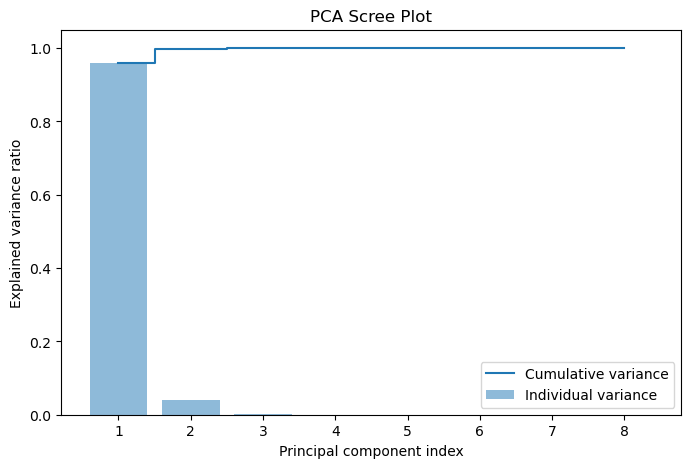

 Data from Sheet3 
Array Dimensions (ndim): 2
 X scaled shape : (99, 8)
 pcs shape : (99, 8)
 length of pca 99
PC | Variance Explained | Cumulative Variance
---------------------------------------------
PC1 | 86.64%            | 86.64%
PC2 | 12.56%            | 99.20%
PC3 | 0.75%            | 99.95%
PC4 | 0.05%            | 100.00%
PC5 | 0.00%            | 100.00%
PC6 | 0.00%            | 100.00%
PC7 | 0.00%            | 100.00%
PC8 | 0.00%            | 100.00%


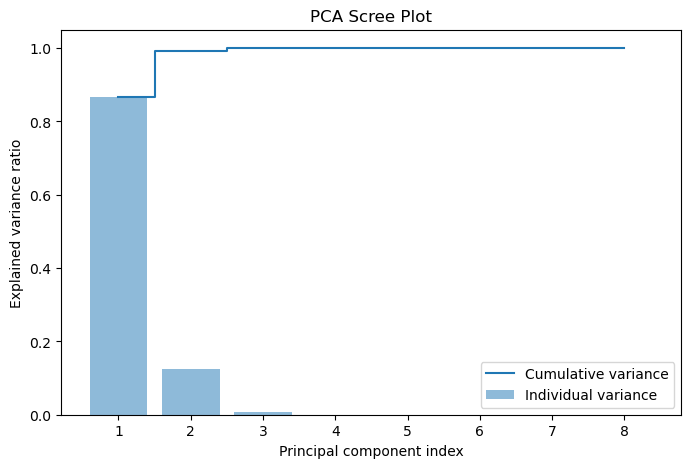

In [ ]:
print("\n" + "=" * 60)
print("PCA on the independent variables.")
print("=" * 60)

X_pca_2d = []

for i in range(len(df)):
    print(" Data from " + sheet_names[i], "\n", "=" * 40)

    X = df[i].iloc[:,1:].copy()

    # 1. Standardize the Data (MANDATORY for PCA)
    # PCA is sensitive to scale, so you must put all features on the same scale
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)  # df is your dataframe with 8 cols

    # 2. Run PCA
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    X_pca_2d.append(X_pca)


    # 3. Calculate Variance Contribution
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    # 4. Print the Results
    print("PC | Variance Explained | Cumulative Variance")
    print("-" * 45)
    for i, (var, cum_var) in enumerate(zip(explained_variance, cumulative_variance)):
        print(f"PC{i+1} | {var*100:.2f}%            | {cum_var*100:.2f}%")

    # 5. Plot the Scree Plot
    plt.figure(figsize=(8, 5))
    plt.bar(range(1, 9), explained_variance, alpha=0.5, align='center', label='Individual variance')
    plt.step(range(1, 9), cumulative_variance, where='mid', label='Cumulative variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal component index')
    plt.legend(loc='best')
    plt.title("PCA Scree Plot")
    plt.show()
    print( "=" * 80)


### Conclusion
``` Massive redundancy in both Sheet 2 and Sheet 3. ```
- More than 99 % of information is in first two principal components. 
- Features are almost duplicates of each other.
- Reduce Dimensions: Instead of using all 8 variables we can simply use PC1 and PC2.
- Original 8 columns ($X_1 \dots X_8$).
- Output: 2 Columns ($PC_1, PC_2$).
- Information Loss: Less than 1% (We keep more than 99% of the signal).

In [113]:
# Assuming 'pca' and 'scaler' are already fitted from the previous step
# X_pca_2d = pca.transform(X_scaled)[:, :2]  # Keep only first 2 columns

for i in range(2):
    print(" Data from " + sheet_names[i], "\n", "=" * 40)

    # Create a new clean dataframe
    df_pca = pd.DataFrame(data=X_pca_2d[i][:, :2], columns=['PC1', 'PC2'])
    df_pca['y'] = df[i].iloc[:,:1] # Add the target back

    print(df_pca.head())
    rows, cols = X_pca_2d[i].shape
    complete_data_df = pd.DataFrame(data=X_pca_2d[i], columns=[f'PC{i}' for i in range(1,cols+1)])
    complete_data_df['y'] = df[i].iloc[:,:1] # Add the target back

    complete_data_df.to_csv(f"sheet {i}.csv", index=False)
    print( "=" * 80)
print(datetime.now())

 Data from Sheet2 
        PC1       PC2         y
0 -4.529980  1.036283  0.974916
1 -3.284457  0.218542  0.879902
2 -2.277266 -0.238993  0.602598
3 -1.352923 -0.499494  0.247088
4 -0.454873 -0.608849  1.116373
 Data from Sheet3 
        PC1       PC2         y
0 -5.977667 -2.179799  0.974916
1 -5.552485 -1.906963  0.879902
2 -5.255141 -1.713747  0.602598
3 -5.011825 -1.553680  0.247088
4 -4.798876 -1.412184  1.116373
2025-11-24 23:20:01.973075


### 6. ML Models with PCA

In [ ]:
columns=[f'PC{i}' for i in range(1,len(X_pca_2d[0])+1)]
print(columns)
columns=[f'PC{i}' for i in range(1,len(X_pca_2d[1])+1)]
print(columns)

['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']
['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20', 'PC21', 'PC22', 'PC23', 'PC24', 'PC25', 'PC26', 'PC27', 'PC28', 'PC29', 'PC30', 'PC31', 'PC32', 'PC33', 'PC34', 'PC35', 'PC36', 'PC37', 'PC38', 'PC39', 'PC40', 'PC41', 'PC42', 'PC43', 'PC44', 'PC45', 'PC46', 'PC47', 'PC48', 'PC49', 'PC50', 'PC51', 'PC52', 'PC53', 'PC54', 'PC55', 'PC56', 'PC57', 'PC58', 'PC59', 'PC60', 'PC61', 'PC62', 'PC63', 'PC64', 'PC65', 'PC66', 'PC67', 'PC68', 'PC69', 'PC70', 'PC71', 'PC72', 'PC73', 'PC74', 'PC75', 'PC76', 'PC77', 'PC78', 'PC79', 'PC80', 'PC81', 'PC82', 'PC83', 'PC84', 'PC85', 'PC86', 'PC87', 'PC88', 'PC89', 'PC90', 'PC91', 'PC92', 'PC93', 'PC94', 'PC95', 'PC96', 'PC97', 'PC98', 'PC99']
